In [1]:
using Plots
using ForwardDiff
using LinearAlgebra
using QuadGK
using Test

In [2]:
include("src/plotters.jl")
include("src/interpolation.jl")
include("src/linesearch.jl")
include("src/transform.jl")
include("src/projection.jl");

## Test of Type Stability

In [3]:
function l2_gradient(q, r)
    # Get the derivatives of the curves q, r, and compute the gradient of the cost function
    qdt(t) = ForwardDiff.derivative(q, t)
    rdt(t) = ForwardDiff.derivative(r, t)
#     diff_norm = l2_distance(q, r)
    function (t)
        return (r(t)⋅qdt(t) - q(t)⋅rdt(t))  # /diff_norm
    end
end 


# Define my test functions
c1(t) = [t, 0]
ψ(t) = 0.9t^2 + 0.1t
c2(t) = [0.9t^2 + 0.1t, 0.]



# ... and their derivatives
c1dt(t) = ForwardDiff.derivative(c1, t)
c2dt(t) = ForwardDiff.derivative(c2, t)
ψdt(t) = 1.8t + 0.1 

# And get the q-maps of my test curves
q = Q_transform(c1, c1dt)
r = Q_transform(c2, c2dt)


# Get the derivatives of the curves q, r, and compute the gradient of the cost function
qdt(t) = ForwardDiff.derivative(q, t)
rdt(t) = ForwardDiff.derivative(r, t)

∇E = l2_gradient(q, r)

#84 (generic function with 1 method)

## Start Visualization

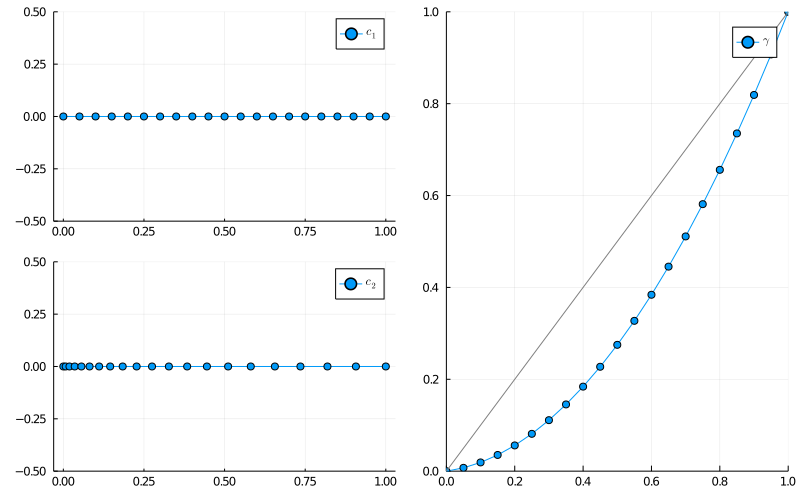

In [4]:
# Create grid of points to evaluate curves, and plot
X = 0:0.05:1
Xfine = 0:0.005:1


# Plot each of the curves, and collect into a single figure
p1 = plot_curve(c1, X, shape=:circle, ylims=(-0.5, 0.5), label="\$c_1\$")
p2 = plot_curve(c2, X, shape=:circle, ylims=(-0.5, 0.5), label="\$c_2\$")
p3 = plot(ψ, X, shape=:circle, label="\$\\gamma\$")
plot!(x -> x, X, width=1., color=:grey, xlims=(0,1), ylims=(0,1), label=:none)

# Collect and plot as a single figure
l = @layout [[a;b] c]
plot(p1, p2, p3, layout=l, size=(800, 500))

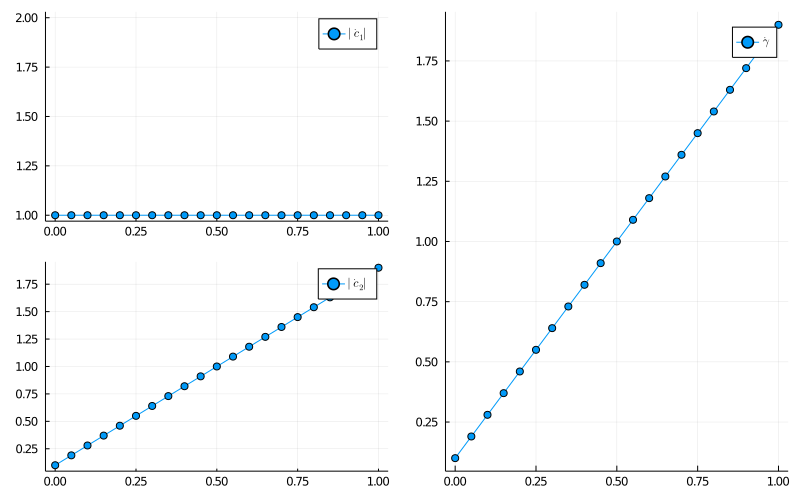

In [5]:
# Plot each of the curves, and collect into a single figure
p1 = plot(x -> norm(c1dt(x)), X, shape=:circle, label="\$|\\dot c_1|\$")
p2 = plot(x -> norm(c2dt(x)), X, shape=:circle, label="\$|\\dot c_2|\$")
p3 = plot(ψdt, X, shape=:circle, label="\$\\dot \\gamma\$")

l = @layout[[a;b] c]

plot(p1, p2, p3, layout=l, size=(800, 500))

## Q-Transform 

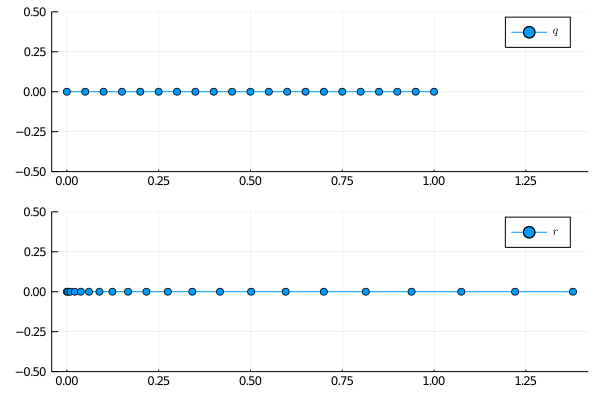

In [6]:
# Assert that the q-transform is properly implemented (by checking composition)
@test all(r.(X) ≈ (x -> sqrt(ψdt(x)) * q(ψ(x))).(X))


# Plot each of the curves, and collect into a single figure
p1 = plot_curve(q, X, shape=:circle, ylims=(-0.5, 0.5), label="\$q\$")
p2 = plot_curve(r, X, shape=:circle, ylims=(-0.5, 0.5), label="\$r\$")
plot(p1, p2, layout=(2,1), link =:x)

## Various Approaches for Gradient Interpolation

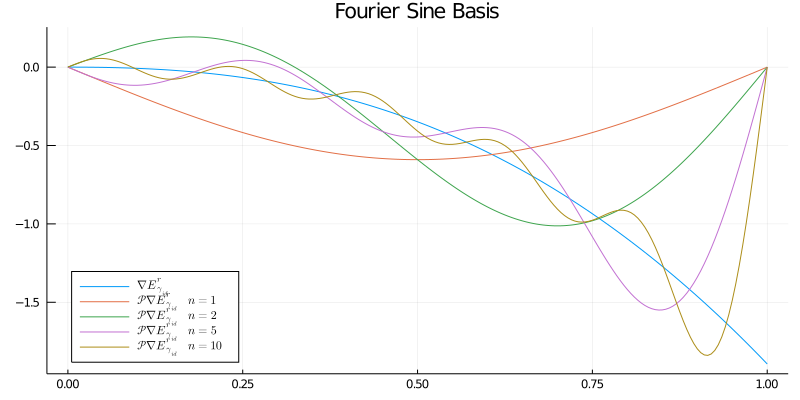

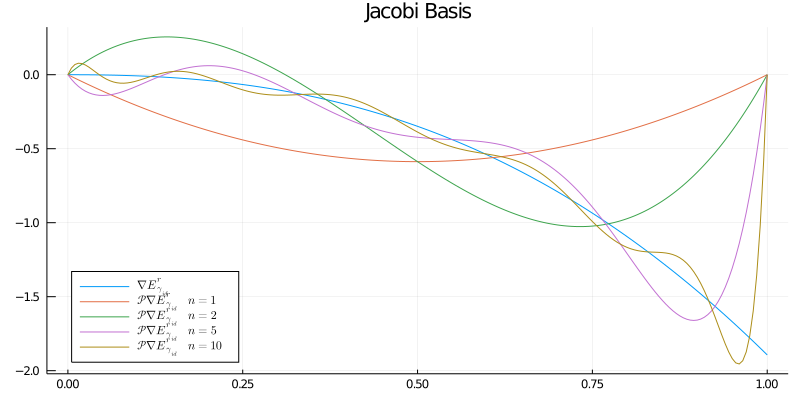

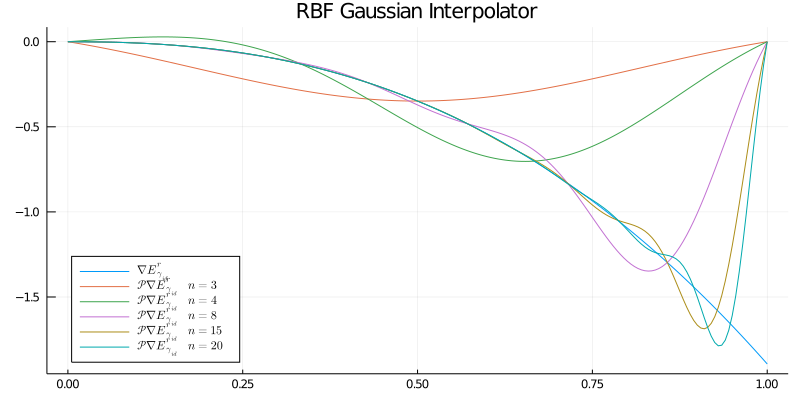

In [7]:
# Plot the gradient, and the projections with fourier basis
p = plot(∇E, Xfine, label="\$\\nabla E^r_{\\gamma_{id}}\$", size=(800, 400), title="Fourier Sine Basis")
for N in [1, 2, 5, 10]
    projE = project(∇E, [x -> √2 * sin(n*π*x) for n in 1:N])
    plot!(projE, Xfine, label="\$\\mathcal{ P }\\nabla E^r_{\\gamma_{id}}\\quad n=$N\$", legend=:bottomleft)
end
display(p)

# Plot the gradient, and the projection with Jacobi basis
p = plot(∇E, Xfine, label="\$\\nabla E^r_{\\gamma_{id}}\$", size=(800, 400), title="Jacobi Basis")

for N in [1, 2, 5, 10]
    projE = project(∇E, basis_jacobi_polynomials(N))
    plot!(projE, Xfine, label="\$\\mathcal{ P }\\nabla E^r_{\\gamma_{id}}\\quad n=$N\$", legend=:bottomleft)
end
display(p)

# Plot the gradient, and the projection with Jacobi basis
p = plot(∇E, Xfine, label="\$\\nabla E^r_{\\gamma_{id}}\$", size=(800, 400), title="RBF Gaussian Interpolator")
for N in [3, 4, 8, 15, 20]
    interpE = interpolate(∇E, N)
    plot!(interpE, Xfine, label="\$\\mathcal{ P }\\nabla E^r_{\\gamma_{id}}\\quad n=$N\$", legend=:bottomleft)
end
display(p)

### Error Comparison for Various Interpolation Approaches

  1.436460 seconds (4.87 M allocations: 301.148 MiB, 3.80% gc time)
  0.146022 seconds (466.12 k allocations: 28.641 MiB, 7.43% gc time)
  0.285191 seconds (612.83 k allocations: 35.441 MiB, 4.07% gc time)


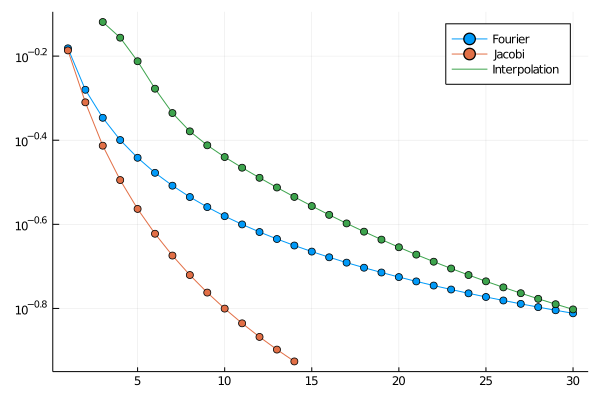

In [8]:
function projection_error_fourier(f, nmax)
    error = Array{Float64}(undef, nmax)
    for N in 1:nmax
        projf = project(f, basis_fourier_sine(N))
        error[N] = l2_distance(f, projf)
    end
    return error
end


function projection_error_jacobi(f, nmax)
    error = Array{Float64}(undef, nmax)
    for N in 1:nmax
        projf = project(f, basis_jacobi_polynomials(N))
        error[N] = l2_distance(f, projf)
    end
    return error
end

function interpolation_error_gaussian(f, nmax)
    error = Array{Float64}(undef, nmax)
    error[1:2] .= NaN
    for N in 3:nmax
        interpf = interpolate(f, N, param=10.)
        error[N] = l2_distance(f, interpf)
    end
    return error
end


projection_error_fourier(∇E, 2)
projection_error_jacobi(∇E, 2)
interpolation_error_gaussian(∇E, 2)

@time error_fourier = projection_error_fourier(∇E, 30)
plot(error_fourier, shape=:circle, label="Fourier", yscale=:log10)

@time error_jacobi = projection_error_jacobi(∇E, 14)
plot!(error_jacobi, shape=:circle, label="Jacobi")

@time error_interp = interpolation_error_gaussian(∇E, 30)
plot!(error_interp, shape=:circle, label="Interpolation")

## Putting it All Together

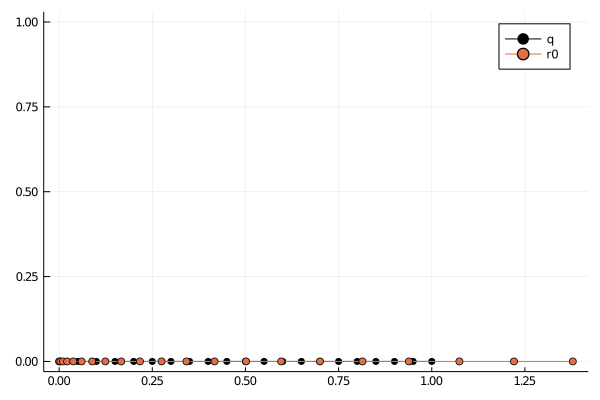

In [9]:
function plot_comparison(r, label)
    plot_curve(q, X, color="black", label="q", shape=:circle)
    plot_curve!(r, X, label=label, shape=:circle)
end
display(plot_comparison(r, "r0"))

In [10]:
include("src/linesearch.jl")
include("src/functionals.jl")

function plot_comparison(r, label; kwargs...)
    plot_curve(q, X, color="black", label="q", shape=:circle; kwargs...)
    plot_curve!(r, X, label=label, shape=:circle)
end

plot_comparison (generic function with 1 method)

In [11]:
function Q_reparametrization(q, γ)
    γdt(t) = ForwardDiff.derivative(γ, t)
    function (t)
        return √(norm(γdt(t))) * q(γ(t))
    end
end

Q_reparametrization (generic function with 1 method)

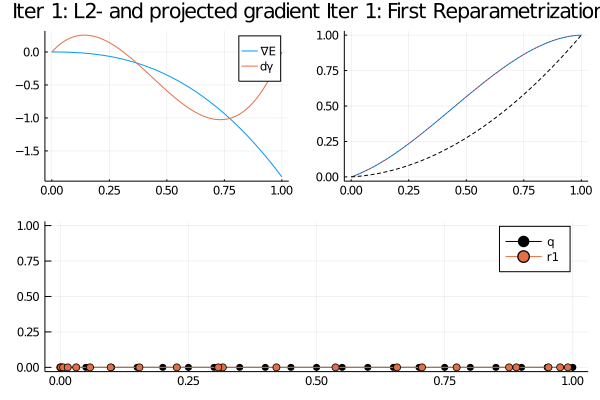

εmax: 0.11096882066399513, ε: 0.11096882066399513, ||dγ|| = 0.6064434333832986


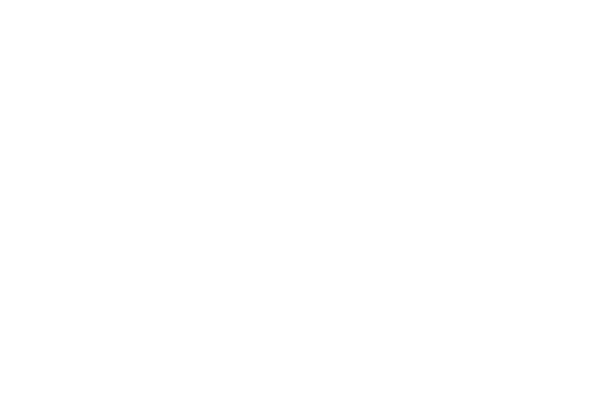

εmax: 0.2579325859028256, ε: 0.2579325859028256, ||dγ|| = 0.5113500075575335


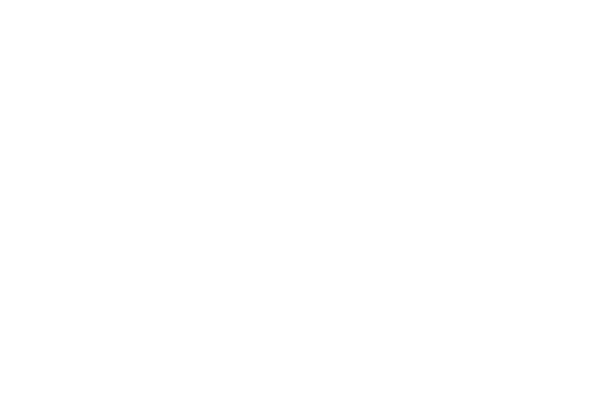

εmax: 0.06569278586389381, ε: 0.06569278586389381, ||dγ|| = 0.9413487791208998


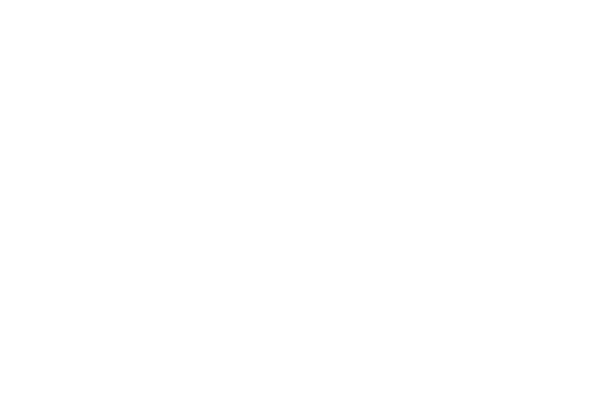

εmax: 0.3653099855173029, ε: 0.3653099855173029, ||dγ|| = 0.36365067286109376


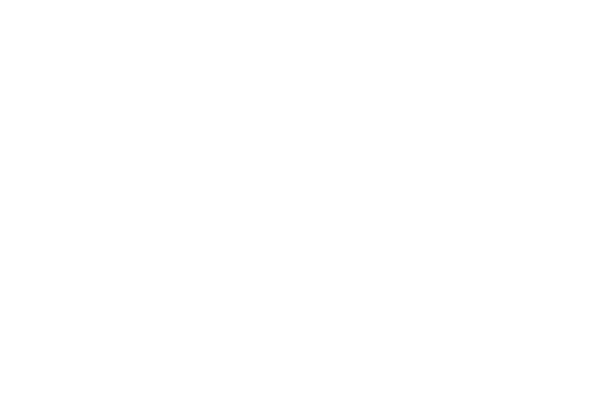

εmax: 0.05057934584762462, ε: 0.05057934584762462, ||dγ|| = 1.2180129477647474


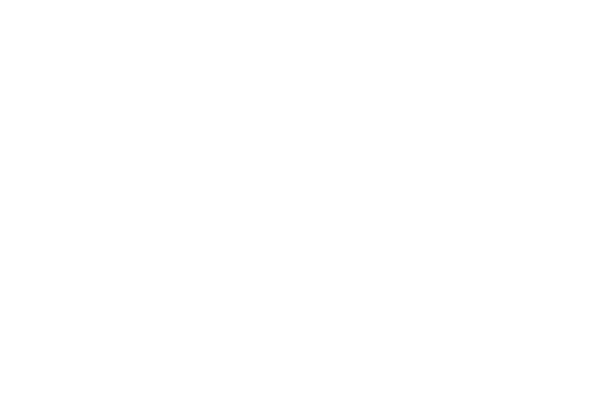

εmax: 0.6417833641320041, ε: 0.6417833641320041, ||dγ|| = 0.23450410732941254


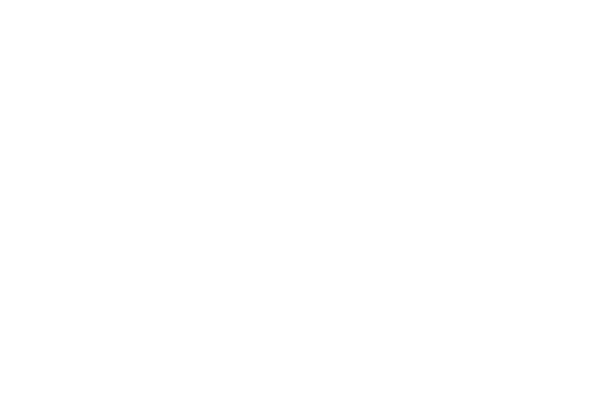

εmax: 0.05986568997983571, ε: 0.05986568997983571, ||dγ|| = 1.0375456603089217


LoadError: InterruptException:

In [14]:
N = 2

# And get the q-maps of my test curves
q = Q_transform(c1, c1dt)
r = Q_transform(c2, c2dt)
l = @layout [a b; c]

basis = basis_jacobi_polynomials(N)

Xcoarse = 0:0.1:1
Xfine = 0:0.01:1

id(x) = x
ϕ = id
for i in 1:20
    ∇E = l2_gradient(q, r)
    dγ = project(∇E, basis)
    
    εmax = max_step_length(dγ)
    ε = backtracking(q, r, dγ, εmax, ρ=0.5, c=0.1)
    ε = εmax
    println("εmax: $εmax, ε: $ε, ||dγ|| = $(l2_norm(dγ))")
    
    γ(x) = x - ε * dγ(x)
    ϕ = ϕ ∘ γ
    
    p1 = plot(∇E, Xfine, title="Iter $i: L2- and projected gradient", label="∇E")
    plot!(dγ, Xfine, label="dγ")
    
    p2 = plot(ϕ, Xfine, title="Iter $i: First Reparametrization", legend=false)
    plot!(γ, Xfine, linestyle=:dash, color="red", linewidth=0.5)
    plot!(ψ, Xfine, linestyle=:dash, color="black")
    
    r = Q_reparametrization(r, γ)
    
    p3 = plot_comparison(r, "r$i")
    
    display(plot(p1, p2, p3, layout=l))    
end